Dataset downloaded to: /kaggle/input/phishing-email-dataset
Loaded 159,163 total rows from 6 CSVs.
Using 'body' as text column and 'label' as label column.

Sample of preprocessed data:
                                                text  label
0  Buck up, your troubles caused by small dimensi...      1
1  \nUpgrade your sex and pleasures with these te...      1
2  >+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...      1
3  Would anyone object to removing .so from this ...      0
4  \nWelcomeFastShippingCustomerSupport\nhttp://7...      1

Class balance:
label
1    53.70%
0    46.30%
Name: proportion, dtype: object

Train size: 61,341  |  Test size: 15,336

--- Bayes with Bag-of-Words (BOW) ---
Train time: 35.1s
Accuracy   : 0.9803
Precision  : 0.9959
Recall     : 0.9673
F1 Score   : 0.9814
AUC        : 0.9977

              precision    recall  f1-score   support

 Ham / Legit       0.96      1.00      0.98      7101
Phish / Spam       1.00      0.97      0.98      8235

    accuracy

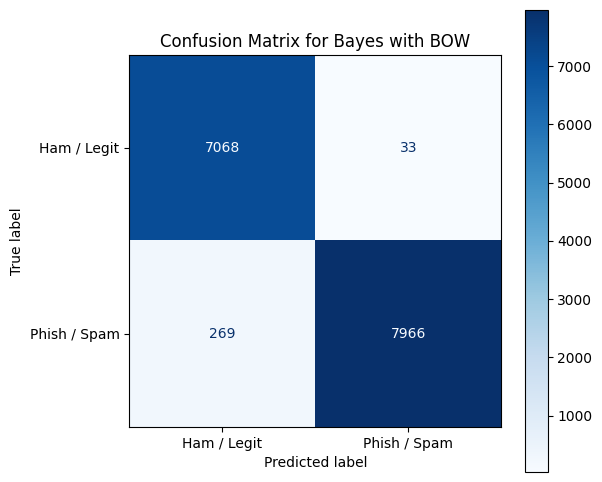


--- Bayes with TF-IDF ---
Train time: 36.7s
Accuracy   : 0.9864
Precision  : 0.9897
Recall     : 0.9849
F1 Score   : 0.9873
AUC        : 0.9991

              precision    recall  f1-score   support

 Ham / Legit       0.98      0.99      0.99      7101
Phish / Spam       0.99      0.98      0.99      8235

    accuracy                           0.99     15336
   macro avg       0.99      0.99      0.99     15336
weighted avg       0.99      0.99      0.99     15336



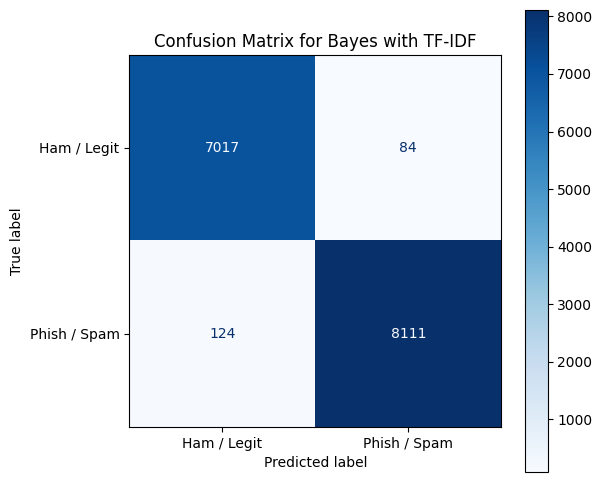

In [2]:
# ─────────────────────────────────────────────
# 0. Imports & Config
# ─────────────────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re, string, os, textwrap
import time

# Scikit-learn Imports
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

plt.style.use("default")
sns.set_palette("Set2")

# ─────────────────────────────────────────────
# 1. Dataset Download & Load
# ─────────────────────────────────────────────
import kagglehub
path = kagglehub.dataset_download("naserabdullahalam/phishing-email-dataset")
print(f"Dataset downloaded to: {path}")

csv_files = [
    "CEAS_08.csv", "Nazario.csv", "Nigerian_Fraud.csv",
    "Enron.csv", "Ling.csv", "phishing_email.csv",
]

dfs = []
for f in csv_files:
    fp = Path(path, f)
    if not fp.exists():
        print(f"Warning: Expected {fp} but it is missing! Skipping.")
        continue
    df = pd.read_csv(fp)
    df["source_file"] = f
    dfs.append(df)

raw = pd.concat(dfs, ignore_index=True)
print(f"Loaded {raw.shape[0]:,} total rows from {len(dfs)} CSVs.")

# ─────────────────────────────────────────────
# 2. Normalise Column Names → 'text' & 'label'
# ─────────────────────────────────────────────
TEXT_COL_CANDIDATES  = ["text", "body", "Email", "Message"]
LABEL_COL_CANDIDATES = ["label", "class", "Category", "phishing"]

def find_first_existing(cols, candidates, kind):
    for c in candidates:
        if c in cols: return c
    raise ValueError(f"No {kind} column found! Candidates tried: {candidates}")

text_col  = find_first_existing(raw.columns, TEXT_COL_CANDIDATES,  "text")
label_col = find_first_existing(raw.columns, LABEL_COL_CANDIDATES, "label")

print(f"Using '{text_col}' as text column and '{label_col}' as label column.")

df = raw[[text_col, label_col]].rename(columns={text_col: "text", label_col: "label"})

if df["label"].dtype == object:
    df["label"] = (
        df["label"].str.lower()
        .apply(lambda x: 1 if re.search(r"(spam|phish|fraud|scam|attack)", str(x)) else 0)
    )

df.dropna(subset=["text"], inplace=True)
df = df.astype({"text": "str", "label": "int"})

print("\nSample of preprocessed data:")
print(df.head())

# ─────────────────────────────────────────────
# 3. Basic EDA
# ─────────────────────────────────────────────
print("\nClass balance:")
print(df["label"].value_counts(normalize=True).apply("{:.2%}".format))


# ─────────────────────────────────────────────
# 4. Train / Test Split
# ─────────────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["label"], test_size=0.2, stratify=df["label"], random_state=42,
)

print(f"\nTrain size: {len(X_train):,}  |  Test size: {len(X_test):,}")

# ─────────────────────────────────────────────
# 5. Build and Evaluate Bayes Models
# ─────────────────────────────────────────────

def train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name=""):
    """Trains a model, prints metrics, and plots its confusion matrix."""
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Print text-based metrics
    print(f"Train time: {train_time:.1f}s")
    print(f"Accuracy   : {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision  : {precision_recall_fscore_support(y_test, y_pred, average='binary')[0]:.4f}")
    print(f"Recall     : {precision_recall_fscore_support(y_test, y_pred, average='binary')[1]:.4f}")
    print(f"F1 Score   : {precision_recall_fscore_support(y_test, y_pred, average='binary')[2]:.4f}")
    print(f"AUC        : {roc_auc_score(y_test, y_pred_proba):.4f}\n")
    print(classification_report(y_test, y_pred, target_names=["Ham / Legit", "Phish / Spam"]))

    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Ham / Legit", "Phish / Spam"])

    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    ax.set_title(f"Confusion Matrix for {model_name}")
    plt.show()

# --- Experiment 1: Bayes with Bag-of-Words (BOW) ---
print("\n" + "="*45)
print("--- Bayes with Bag-of-Words (BOW) ---")
print("="*45)

bow_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(stop_words="english", ngram_range=(1, 2), min_df=2)),
    ('classifier', MultinomialNB(alpha=1.0))
])

train_and_evaluate(bow_pipeline, X_train, y_train, X_test, y_test, model_name="Bayes with BOW")


# --- Experiment 2: Bayes with TF-IDF ---
print("\n" + "="*45)
print("--- Bayes with TF-IDF ---")
print("="*45)

tfidf_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words="english", ngram_range=(1, 2), min_df=2)),
    ('classifier', MultinomialNB(alpha=1.0))
])

train_and_evaluate(tfidf_pipeline, X_train, y_train, X_test, y_test, model_name="Bayes with TF-IDF")